# Verify that the baseline curves can fit the fresh data.

04/30/2023

Andrew Weng

Make sure to `brew install ffmpeg` to get the animation to save.

In [2]:
# %matplotlib widget
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src import plotter as plotter
from scipy.signal import savgol_filter as savgol_filter
from src import dvdq as dvdq
from src import modelutils as mu
from scipy import interpolate

plotter.initialize(plt)

%load_ext autoreload


# Load the Experimental Data

In [3]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65

elif cellid == 152074: # BASELINE FORMATION (repeat 2)

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

df_arbin = df_arbin[df_arbin['Cycle Number'] == 39]
df_arbin = df_arbin[df_arbin['Step Index'] == 24]

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tt = (tv - np.min(tv)) / 1e9
vv = df_arbin['Potential (V)']

size_factor = 65
window_length = int(len(tt) / size_factor)
window_length = window_length + 1 if window_length % 2 == 0 else window_length
polyorder = 2

# SG filter on the data to make it smooth
dq1 = savgol_filter(qq, window_length, polyorder, 1)
dv1 = savgol_filter(vv, window_length, polyorder, 1)

out = dict()
out['chg_capacity'] = qq
out['chg_voltage'] = vv
out['chg_dvdq'] = dv1/dq1
df_out = pd.DataFrame(out)
df_out.to_csv(f'diagnostic_test_cell_umbl2022feb_cell{cellid}.csv')


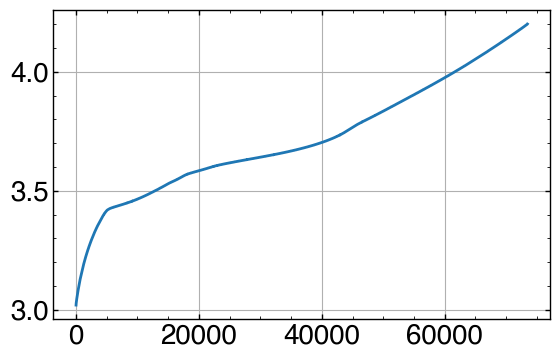

In [4]:
plt.figure(figsize=(6,4))
plt.plot(tt, vv)


# Load the Resistance Data

In [5]:
df_resistance = pd.read_csv('data/processed/hppc_1.csv')

In [6]:
%autoreload
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/weng2021.yaml')


# Baseline Formation
sim1 = cellsim.Simulation(cell, 2000*3600)

sim1.run_rest(1, rest_time_hrs=3.0)
sim1.run_chg_cccv(2, 2.37/10, Icv, vmax)
sim1.run_dch_cccv(2, Idch, Idch, vmin)
sim1.run_chg_cccv(3, 2.37/10, Icv, vmax)
sim1.run_dch_cccv(3, Idch, Idch, vmin)
sim1.run_chg_cccv(4, 2.37/10, Icv, vmax)
sim1.run_rest(4, rest_time_hrs=6)
sim1.run_dch_cccv(4, Idch, Idch, vmin)

df_sim1 = sim1.get_results()

# Fast Formation
sim2 = cellsim.Simulation(cell, 2000*3600)

sim2.run_rest(1, rest_time_hrs=3.0)
sim2.run_chg_cccv(2, 2.37, 2.37, 3.9)
sim2.run_chg_cccv(2, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(2, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(3, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(3, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(4, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(4, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(5, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(5, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(6, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(6, -2.37/5, 2.37/5, 3.9)
sim2.run_dch_cccv(6, -2.37/1, 2.37/1, 3.0)

# RPT
# sim2.run_chg_cccv(6, +2.37/10, +2.37/10, vmax)
# sim2.run_dch_cccv(6, -2.37/10, 2.37/10, vmin)
# sim2.run_chg_cccv(7, +2.37/10, +2.37/10, vmax)
# sim2.run_rest(    7, rest_time_hrs=10.6)
# sim2.run_dch_cccv(7, -2.37/10, 2.37/10, vmin)

df_sim2 = sim2.get_results()


Running Cyc1: Rest for 3.0 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Rest for 6 hours...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 3.0 hours...
Running Cyc2: Charge to 3.9V...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.9V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.9V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.9V...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.9V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Discharge to 3.9V...
Running Cyc6: Discharge to 3.0V...


In [7]:
def setup(type, figsize=(10,8)):
    """
    Set up the figure

    Parameters
    ----------
    type : str
       'res' for resistance plot as the second panel
       'dvdq' for dV/dQ plot as the second panel
       'time'series for voltage timeseries as the second plot
    Returns the figure and axis handles
    """

    gridspec = dict(hspace=0.25, height_ratios=[2,1])

    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1,
                                gridspec_kw=gridspec,
                                figsize=figsize)

    ax1.set_ylim((-0.4, 4.5))
    ax1.set_ylabel('Voltage [V]')

    # Initialize an empty text handle
    th1 = ax1.text(0.1, 2.7, '', fontsize=20)
    th2 = ax2.text(0.1, 80, '', fontsize=20)

    # ax2.set_yticks([0, 0.50, 1, 1.5, 2.0, 3, 4.2])
    # ax2.set_yticklabels([0, 0.50, 1, 1.5, 2.0, 3, 4.2])

    ax1.set_xlabel('Capacity [Ah]')

    if type == 'time':
        ax2.set_xlabel('Time [hrs]')
        ax2.set_ylabel('Voltage [V]')
    else:
        ax2.set_xlabel(r'$q$ [Ah]')
        ax2.set_xticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

    if type == 'res':
        ax2.set_ylabel(r'$R_{10s}$ [$m\Omega$]')
        ax2.set_ylim((0, 120))
    elif type == 'dvdq':
        ax2.set_ylabel(r'd$V$/d$q$ [V/Ah]')
        ax2.set_ylim((0, 0.6))

    # Set shared axis settings
    for ax in [ax1, ax2]:
        ax.set_xlim((-0.1, 3.8))
        ax.grid(False)

    if type == 'time':
        ax2.set_xlim(left=0, right=None)

    fig.align_ylabels(axs=[ax1, ax2])

    return fig, [ax1, ax2], [th1, th2]

In [30]:
def draw(axs, type, ths, t, params, df_sim):
    """
    Draw figure elements

    Parameters
    ---------
    axs: array of axis handles
    type: 'res'istance plot or 'dvdq' plot or 'time'series plot
    ths: array of text handles
    t: simulation time in seconds
    params: parameters (tuple)
    df_sim : simulation dataframe
    """

    # Unpack the inputs
    ax1, ax2 = axs
    Q_p, Q_n = params
    th1, th2 = ths


    idx = df_sim['t'] < t
    if idx is None:
        theta_n_curr = df['theta_n'].iloc[0]
        theta_p_curr = df['theta_p'].iloc[0]
        q_sei = df['q_sei'].iloc[0]
    else:
        df = df_sim[idx]
        theta_n_curr = df['theta_n'].iloc[-1]
        theta_p_curr = df['theta_p'].iloc[-1]
        q_sei = df['q_sei'].iloc[-1]


    theta_vec = np.linspace(0, 1, 1000)
    # Unpack the parameters vector

    (f_rpos, f_rneg) = mu.get_resistance_curves()

    qpos = Q_p * (1 - theta_vec)
    vpos = mu.Up(theta_vec)
    rpos = f_rpos(theta_vec)
    qneg = Q_n * theta_vec + q_sei
    vneg = mu.Un(theta_vec)
    rneg = f_rneg(theta_vec)

    q_n_curr = Q_p * (1 - theta_p_curr)
    q_p_curr = Q_n * theta_n_curr + q_sei
    v_p_curr = mu.Up(theta_p_curr)
    v_n_curr = mu.Un(theta_n_curr)
    r_p_curr = f_rpos(theta_p_curr)
    r_n_curr = f_rneg(theta_n_curr)

    # Reconstruct the full cell curves from the half cell data
    f_qp = interpolate.interp1d(qpos, vpos, bounds_error=False, fill_value=np.NaN)
    f_qn = interpolate.interp1d(qneg, vneg, bounds_error=False, fill_value=np.NaN)
    f_rp = interpolate.interp1d(qpos, rpos, bounds_error=False, fill_value=np.NaN)
    f_rn = interpolate.interp1d(qneg, rneg, bounds_error=False, fill_value=np.NaN)

    qfull = np.linspace(0, Q_p, 1000)
    vfull = f_qp(qfull) - f_qn(qfull)
    rfull = f_rp(qfull) + f_rn(qfull)

    f_full_inv = interpolate.interp1d(vfull, qfull)
    qmin = f_full_inv(3.0)
    qmax = f_full_inv(4.2)
    qcell = qmax - qmin

    f_full_r = interpolate.interp1d(qfull, rfull)
    r_full_ref = f_full_r(qmin)

    # dvdq_meas = np.gradient(Voc)/np.gradient(q)*np.max(q)
    dvdq_pos = np.gradient(vpos)/np.gradient(qpos)
    dvdq_neg = np.gradient(vneg)/np.gradient(qneg)
    dvdq_full = np.gradient(vfull)/np.gradient(qfull)

    # Clear line objects
    for ax in axs:
        for l in ax.get_lines():
            l.remove()

    # Make the cathode and full cell voltage plot
    # ax1.plot(qq, vv, c='k', ls='--') # the data
    ax1.plot(qfull, vfull, c='k', ls='-')
    ax1.plot(q_p_curr, f_qp(q_p_curr) - f_qn(q_n_curr), marker='o', markersize=9, c='k')
    ax1.plot(qpos, vpos, 'b')
    ax1.plot(q_p_curr, v_p_curr, marker='o', markersize=9, c='b')

    th1.set_position((qmin+0.05, 1.0))
    th1.set_text(f'$t={t/60:.1f}$ mins \n$Q_{{\mathrm{{sei}}}}={q_sei:.3f}$ Ah \n$Q_{{\mathrm{{cell}}}}={qcell:.3f}$ Ah')

    # Make the anode voltage plot
    ax1.plot(q_n_curr, v_n_curr, marker='o', markersize=8, c='r')
    ax1.plot(qneg, vneg, 'r')

    # Make the dV/dQ plot
    # ax3.plot(qq, dv1/dq1, c='k', ls='--')
    if type == 'dvdq':
        ax2.plot(qfull, dvdq_full, c='k', ls='-')
        ax2.plot(qpos, dvdq_pos, 'b')
        ax2.plot(qneg, -dvdq_neg, 'r')
    elif type == 'res':
        ax2.plot(qfull, rfull*1e3, c='k', ls='-')
        ax2.plot(qpos, rpos*1e3, 'b')
        ax2.plot(qneg, rneg*1e3, 'r')
        ax2.plot(q_p_curr, r_p_curr*1e3, marker='o', markersize=8, c='b')
        ax2.plot(q_n_curr, r_n_curr*1e3, marker='o', markersize=8, c='r')
        ax2.plot(qmin, r_full_ref*1e3, marker='o', markersize=8, c='k')
        th2.set_position((qmin+0.02, r_full_ref*1e3+3))
        th2.set_text(f'$R_{{\mathrm{{LS}}}} = {r_full_ref*1e3:.1f} $ m$\Omega$')
    elif type == 'time':
        idx = df_sim['t'] < t
        time_in_hrs = df_sim['t'][idx] / 3600
        vfull = df_sim['vt'][idx]
        vpos = df_sim['ocv_p'][idx]
        vneg = df_sim['ocv_n'][idx]
        ax2.plot(time_in_hrs, vfull, c='k', ls='-')
        ax2.plot(time_in_hrs.iloc[-1], vfull.iloc[-1], c='k', ls='-', marker='o', markersize=8)
        ax2.plot(time_in_hrs, vneg, c='r', ls='--')
        ax2.plot(time_in_hrs.iloc[-1], vneg.iloc[-1], c='r', ls='-', marker='o', markersize=8)
        ax2.plot(time_in_hrs, vpos, c='b', ls='--')
        ax2.plot(time_in_hrs.iloc[-1], vpos.iloc[-1], c='b', ls='-', marker='o', markersize=8)
        ax2.set_xlim((0, 1.1 * t/3600))


    # Vertical bars indicating 0% and 100% SOC
    axtoshow = [ax1] if type == 'time' else axs
    for ax in axtoshow:
        ax.axvline(x=qmin, ymin=0, ymax=100, c='k', linewidth=1, linestyle=':')
        ax.axvline(x=qmax, ymin=0, ymax=100, c='k', linewidth=1, linestyle=':')




In [16]:
def calculate_rls(params, q_sei):
    """
    Calculate Low-SOC resistance given a set of parameters

    Parameters
    ---------
    params: parameters (tuple)
    """

    Q_p, Q_n = params

    theta_vec = np.linspace(0, 1, 1000)
    # Unpack the parameters vector

    (f_rpos, f_rneg) = mu.get_resistance_curves()

    qpos = Q_p * (1 - theta_vec)
    vpos = mu.Up(theta_vec)
    rpos = f_rpos(theta_vec)
    qneg = Q_n * theta_vec + q_sei
    vneg = mu.Un(theta_vec)
    rneg = f_rneg(theta_vec)

    # Reconstruct the full cell curves from the half cell data
    f_qp = interpolate.interp1d(qpos, vpos, bounds_error=False, fill_value=np.NaN)
    f_qn = interpolate.interp1d(qneg, vneg, bounds_error=False, fill_value=np.NaN)
    f_rp = interpolate.interp1d(qpos, rpos, bounds_error=False, fill_value=np.NaN)
    f_rn = interpolate.interp1d(qneg, rneg, bounds_error=False, fill_value=np.NaN)

    qfull = np.linspace(0, Q_p, 1000)
    vfull = f_qp(qfull) - f_qn(qfull)
    rfull = f_rp(qfull) + f_rn(qfull)

    f_full_inv = interpolate.interp1d(vfull, qfull)
    qmin = f_full_inv(3.0)

    f_full_r = interpolate.interp1d(qfull, rfull)
    rls = f_full_r(qmin)

    return rls

In [12]:
Cp = 3.02 # Ah
Cn = 3.14

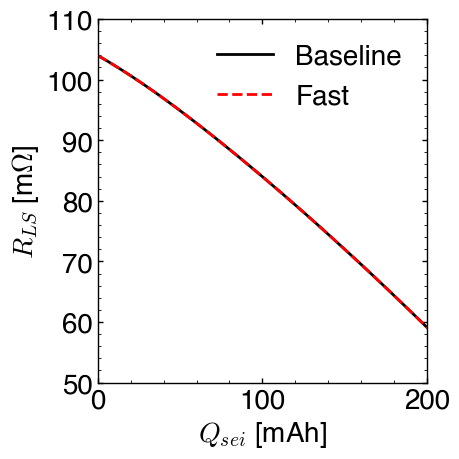

In [28]:
# Get the rls vector and plot it

qsei1 = df_sim1['q_sei']

qq1 = np.linspace(qsei1.min(), qsei1.max(), 100)

rls1_vec = []
for qsei in qq1:
    rls1_vec.append(calculate_rls((Cp, Cn), qsei))
rls1_vec = np.array(rls1_vec)

qsei2 = df_sim2['q_sei']
qq2 = np.linspace(qsei2.min(), qsei2.max(), 100)
rls2_vec = []
for qsei in qq2:
    rls2_vec.append(calculate_rls((Cp, Cn), qsei))
rls2_vec = np.array(rls2_vec)

plt.figure(figsize=(5,5))
plt.grid(False)
plt.plot(qq1 * 1e3, rls1_vec * 1e3, c='k', label='Baseline')
plt.plot(qq2 * 1e3, rls2_vec * 1e3, c='r', ls='--', label='Fast')
plt.xlabel('$Q_{sei}$ [mAh]')
plt.ylabel('$R_{LS}$ [m$\Omega$]')
plt.xlim((0, 200))
plt.ylim((50, 110))
plt.legend()


In [31]:
def animate(idx_frame, axs, type, th, sim_out, df_sim):
    """
    Animation function that gets iteratively called to render frames

    Parameters
    ----------
    idx_frame : int
        Frame index
    axs : np.array
        array of axis handles
    type : str
        'res' or 'dvdq' or 'time'
    th : np.array
        array of text handles
    sim_out : tuple
        (Cp, Cn)
            Cp (float): cathode capacity
            Cn (float): anode capacity
    df_sim : pd.DataFrame
        DataFrame with the simulation results
    """

    # Convert frame index to real time
    dt_sim = 5 # seconds
    factor = 60
    t = (idx_frame + 1)  * dt_sim * factor

    draw(axs, type, th, t, sim_out, df_sim)


# Draw a single frame for testing purposes

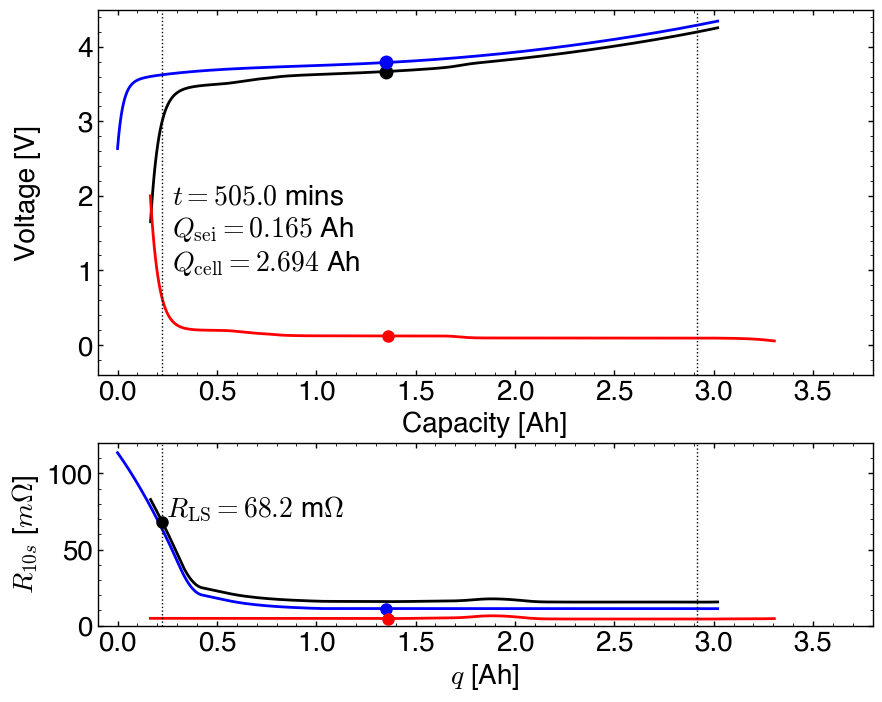

In [33]:
type = 'res'
fig, axs, th = setup(type)
idx_frame = 100
animate(idx_frame, axs, type, th, (Cp, Cn), df_sim1)

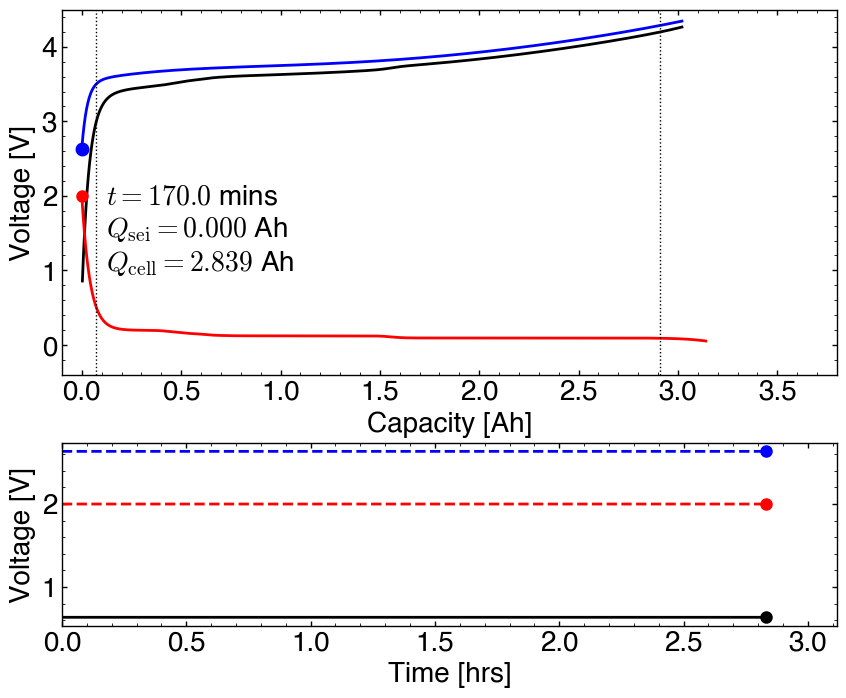

In [180]:
type = 'time'
fig, axs, th = setup(type)
idx_frame=100
animate(33, axs, type, th, (Cp, Cn), df_sim1)

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_98327/1969377695.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ani.save(r'animation_base_res.mp4', writer=writer)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


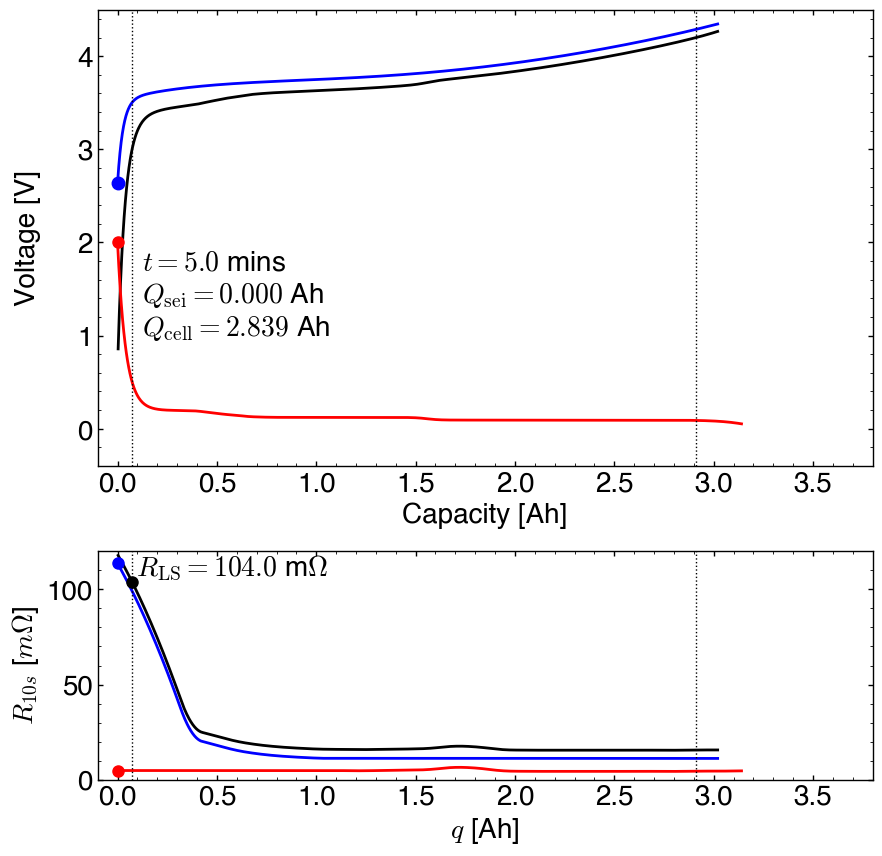

In [34]:
type = 'res'
interval_ms = 100

DF_TARGET = df_sim1

num_frames = int(len(DF_TARGET['t']) / 60)

fig, axs, th = setup(type, figsize=(10,10))

ani = animation.FuncAnimation(fig, animate, frames=num_frames,
                    fargs=(axs, type, th, (Cp, Cn), DF_TARGET),
                    interval=interval_ms)

# writergif = PillowWriter(fps=30)
writer = animation.FFMpegWriter(fps=15)

ani.save(r'animation_base_res.mp4', writer=writer)